# Predicting ENSO
### Source: Libby Barnes
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/ml_tutorial_csu/tree/main/code/)
### Edited by: Kirsten Mayer & Will Chapman
Here we are training a classifier to predict whether an El Nino or La Nina event is occuring. The input is a map of global SST, and the output is a classification of either 1=El Nino or 0=La Nino

### Load Libraries

In [1]:
import wget

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

# set seeds
random_seed = 36
np.random.seed(random_seed)
tf.random.set_seed(int(random_seed))

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.size'] = 12

2023-06-20 11:11:54.058242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 11:11:54.669373: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 11:11:58.820979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/dav/opt/cuda/11.4.0/extras/CUPTI/lib64:/glade/u/apps/dav/opt/cuda/11.4.0/lib64:/glade/u/apps/dav/opt/openmpi/4.1.1/intel/19.1.1/lib:/glade/u/apps/dav/opt/ucx/1.11.0/lib:/glade/u/apps/opt/int

## Preprocessing
Load in the data from the netcdf. This is ERSSTv5 which has been deseasoned, linearly detrended, and has a 5 month lookback running mean applied. From this, we can calculate the Nino3.4 index.

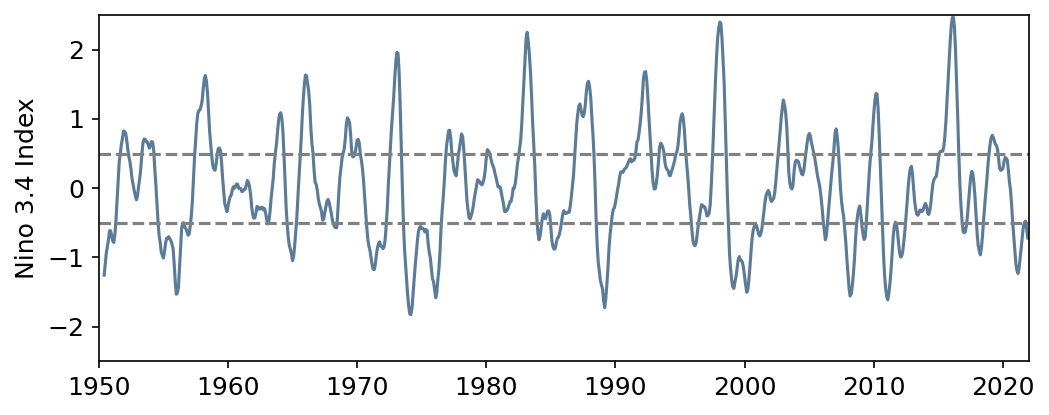

In [2]:
#url = 'https://eabarnes-data.atmos.colostate.edu/tutorials/ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc'
filename = 'ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc' #wget.download(url)
sstds = xr.open_dataset(filename,decode_times=False)
sst = sstds.sst
sst = sst.where((sst.lat <= 30) & (sst.lat >= -30), drop=True)
lat = np.asarray(sst.lat)
lon = np.asarray(sst.lon)
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.show()

## Data preparation
First, we need to include only samples where nino event is occuring (i.e. nino3.4>0.5 or nino3.4<-0.5). Then, we will divide the sst input and nino3.4 output into training, validation and testing chunks.

In [3]:
nino_occur = nino34[(nino34>0.5) | (nino34<-0.5)] # only samples where nino event occurs
nino_occur[nino_occur>0.5] = 1 # make into categorical format, 1 for El Nino and 0 for La Nina
nino_occur[nino_occur<0.5] = 0
nino_occur = tf.keras.utils.to_categorical(nino_occur) # format accepted by NN
sizefull = nino_occur.shape[0]

train_val_test = [0.7,0.85,1] # set train/val/test fraction

sst = np.asarray(sst)
sizesst = sst.shape
sstnino_occur = sst[(nino34>0.5) | (nino34<-0.5),:,:] # grab sst samples where nino occurs
sstnino_occur = np.reshape(sstnino_occur,(sizefull,sizesst[1]*sizesst[2])) # reshape latxlon to vectors

trainind = range(int(train_val_test[0]*sizefull))
valind = range(int(train_val_test[0]*sizefull),int(train_val_test[1]*sizefull))
testind = range(int(train_val_test[1]*sizefull),int(train_val_test[2]*sizefull))

# divide into training/validation/testing
sst_train = sstnino_occur[trainind,:]
sst_val = sstnino_occur[valind,:]
sst_test = sstnino_occur[testind,:]

nino_train  = nino_occur[trainind]
nino_val = nino_occur[valind]
nino_test = nino_occur[testind]

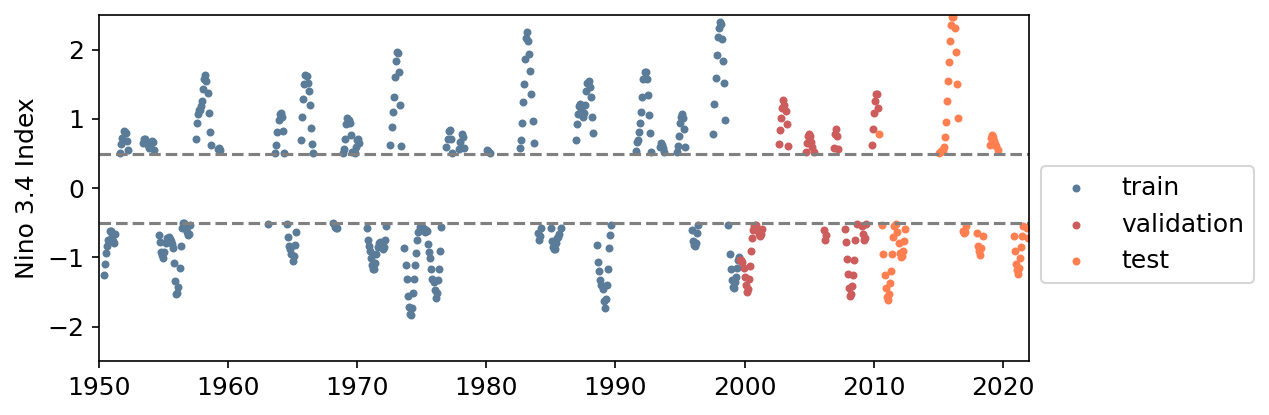

In [4]:
plt.figure(figsize=(8,3))
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][trainind],nino34[(nino34>0.5) | (nino34<-0.5)][trainind],color='xkcd:slate blue', s=8, label = "train")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][valind],nino34[(nino34>0.5) | (nino34<-0.5)][valind],color='indianred', s=8, label = "validation")
plt.scatter(timevec[(nino34>0.5) | (nino34<-0.5)][testind],nino34[(nino34>0.5) | (nino34<-0.5)][testind],color='coral', s=8, label = "test")
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.ylabel("Nino 3.4 Index")
plt.legend(bbox_to_anchor=(1, 0.4, .1, 0.2))
plt.show()

In [5]:
sst_std = np.std(sst_train,axis=0) # standardized by the TRAINING STD

sst_train = np.divide(sst_train,sst_std)
sst_train[np.isnan(sst_train)] = 0 # set all nans to zeros (they are learned to be ignored)
sst_val = np.divide(sst_val,sst_std)
sst_val[np.isnan(sst_val)] = 0
sst_test = np.divide(sst_test,sst_std)
sst_test[np.isnan(sst_test)] = 0

## Neural Network

### Set some neural network parameters
Here we define parts of the neural network architecture and training parameters

In [7]:
# parameters to play with

hiddens = [12, 12] # hidden layers e.g. [10,20] means two hidden layers, 10 nodes connected to 20 nodes
ridgepen = 1 # L2/ridge penalty applied to input
lr = 0.001 # learning rate
n_epochs = 20 # number training epochs
batch_size = 32
activation = 'relu'
loss = 'categorical_crossentropy' 

Epoch 1/20


2023-05-31 09:03:00.322587: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-31 09:03:00.322629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc35): /proc/driver/nvidia/version does not exist
2023-05-31 09:03:00.325566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11/11 - 1s - loss: 146.7285 - categorical_accuracy: 0.5000 - val_loss: 118.2870 - val_categorical_accuracy: 0.7000 - 548ms/epoch - 50ms/step
Epoch 2/20
11/11 - 0s - loss: 101.9960 - categorical_accuracy: 0.8333 - val_loss: 81.7768 - val_categorical_accuracy: 0.8429 - 34ms/epoch - 3ms/step
Epoch 3/20
11/11 - 0s - loss: 70.4062 - categorical_accuracy: 0.9537 - val_loss: 56.4168 - val_categorical_accuracy: 0.9429 - 34ms/epoch - 3ms/step
Epoch 4/20
11/11 - 0s - loss: 48.5948 - categorical_accuracy: 0.9815 - val_loss: 39.0211 - val_categorical_accuracy: 0.9714 - 33ms/epoch - 3ms/step
Epoch 5/20
11/11 - 0s - loss: 33.6465 - categorical_accuracy: 0.9846 - val_loss: 27.1076 - val_categorical_accuracy: 1.0000 - 37ms/epoch - 3ms/step
Epoch 6/20
11/11 - 0s - loss: 23.4062 - categorical_accuracy: 0.9846 - val_loss: 18.9271 - val_categorical_accuracy: 1.0000 - 34ms/epoch - 3ms/step
Epoch 7/20
11/11 - 0s - loss: 16.3675 - categorical_accuracy: 0.9877 - val_loss: 13.2861 - val_categorical_accuracy: 1

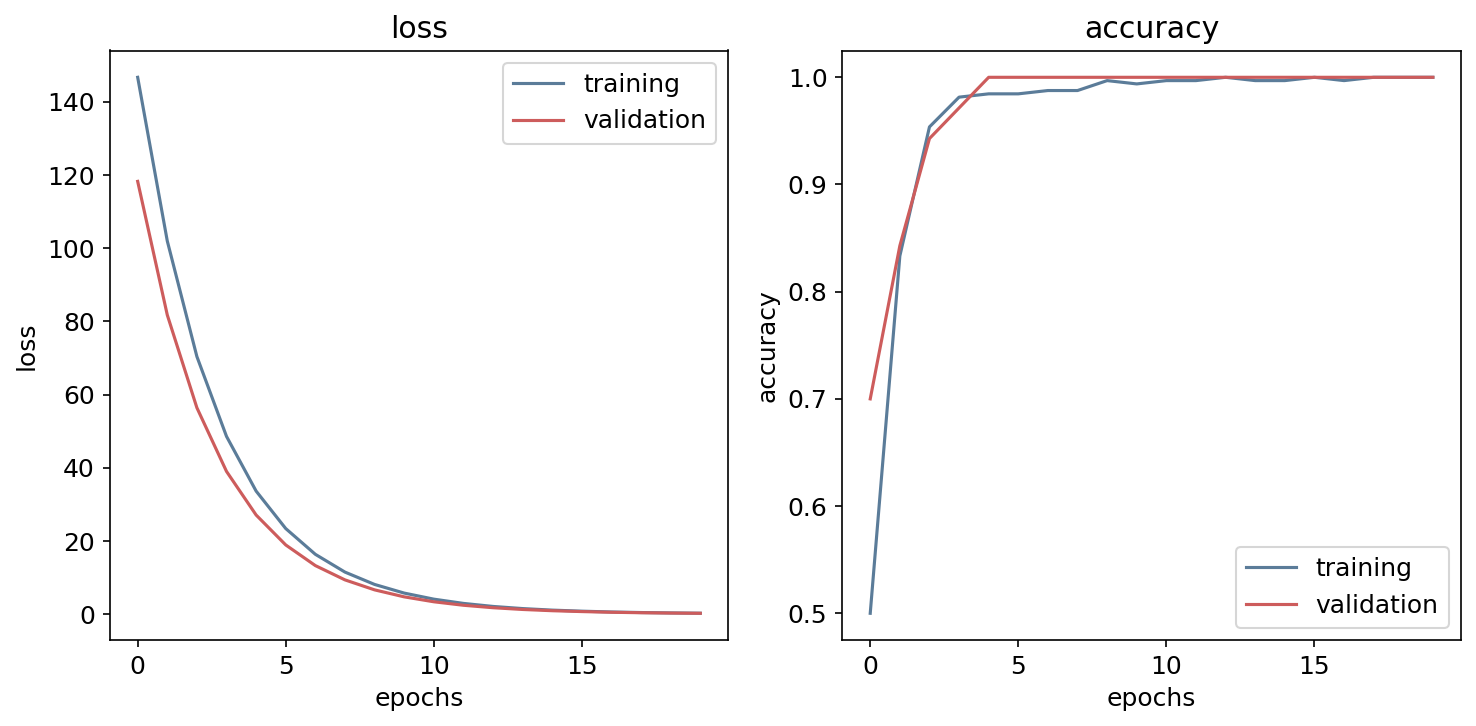

In [7]:
n_layers = len(hiddens)
output_nodes = 2

# define the model
model = Sequential()

model.add(Dense(hiddens[0], activation=activation,input_shape=(sst_train.shape[-1],),
            bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
            kernel_regularizer=regularizers.L2(l2=ridgepen)))

# add hidden layers
for layer in range(1,n_layers):
    model.add(Dense(hiddens[layer], activation=activation,
                    bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                    kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed)))

# final layer
model.add(Dense(output_nodes,activation='softmax',
                bias_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),
                kernel_initializer=tf.keras.initializers.RandomNormal(seed=random_seed),))

# compile
model.compile(optimizer=optimizers.Adam(lr),  
              loss=loss,   
              metrics=[metrics.categorical_accuracy]) 

# train
history = model.fit(sst_train, nino_train, epochs=n_epochs, batch_size=batch_size, validation_data=(sst_val, nino_val), 
                    shuffle=True, verbose=2)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_loss'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'],color='xkcd:slate blue',label='training')
plt.plot(history.history['val_categorical_accuracy'],color='indianred',label='validation')
plt.xlabel("epochs"); plt.ylabel("accuracy")
plt.title("accuracy")
plt.legend()

plt.tight_layout()

## Model evaluation
How does the model do on unseen data?

In [8]:
nino_pred = model.predict(sst_test) # make predictions for test data

nino_pred = np.argmax(nino_pred,axis=1)
nino_true = np.argmax(nino_test,axis=1)

modelcorr = nino_pred==nino_true
nmodelcorr = modelcorr[modelcorr].shape[0]
ntest = nino_true.shape[0]
print('Model accuracy on testing is %f%%' %(100*nmodelcorr/ntest))

3/3 [==============================] - 0s 3ms/step
Model accuracy on testing is 100.000000%


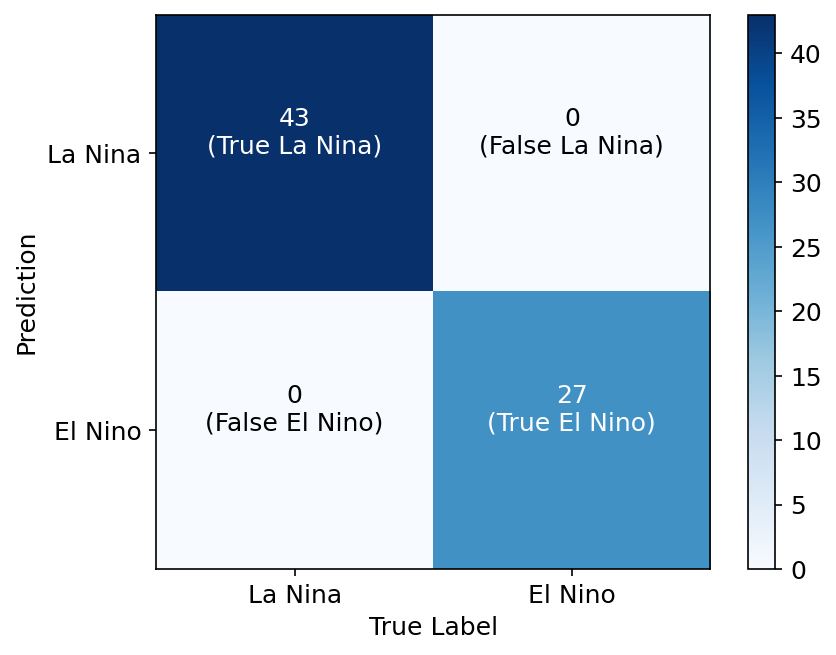

In [9]:
# confusion matrix

cm = tf.math.confusion_matrix(nino_true, nino_pred).numpy()
plt.imshow(cm, cmap = "Blues")
plt.text(x = 0, y = 0, s=str(cm[0,0]) + "\n(True La Nina)", color = "w", ha = "center")
plt.text(x = 0, y = 1, s=str(cm[0,1]) + "\n(False El Nino)", ha = "center")
plt.text(x = 1, y = 0, s=str(cm[1,0]) + "\n(False La Nina)", ha = "center")
plt.text(x = 1, y = 1, s=str(cm[1,1]) + "\n(True El Nino)", color = "w", ha = "center")
plt.xlabel("True Label")
plt.ylabel("Prediction")
plt.colorbar()
plt.xticks((0,1), labels = ["La Nina", "El Nino"])
plt.yticks((0,1), labels = ["La Nina", "El Nino"]);

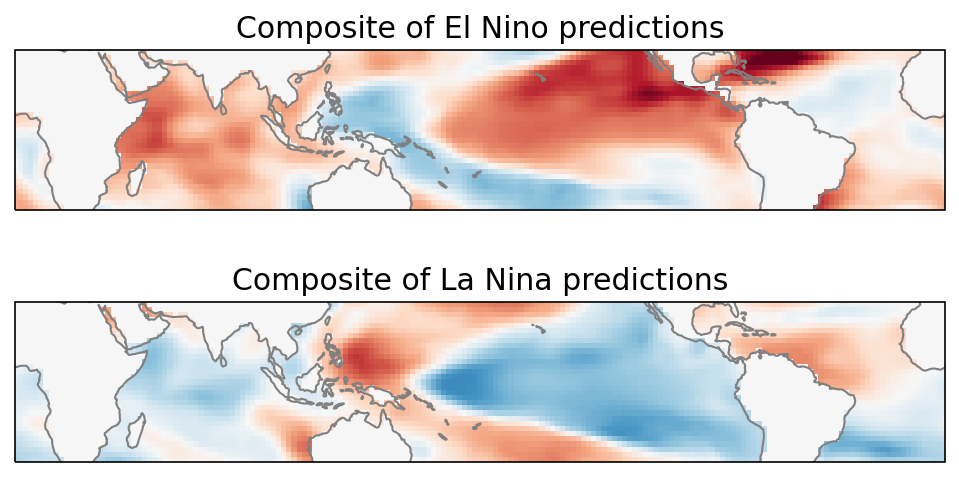

In [13]:
elninopred = (nino_pred==1)
laninapred = (nino_pred==0)

elnino_sst = sst_test[elninopred,:]
elnino_sst = np.reshape(elnino_sst,(elnino_sst.shape[0],sizesst[1],sizesst[2]))
lanina_sst = sst_test[laninapred,:]
lanina_sst = np.reshape(lanina_sst,(lanina_sst.shape[0],sizesst[1],sizesst[2]))

elninoplot = np.mean(elnino_sst,axis=0)
laninaplot = np.mean(lanina_sst,axis=0)

projection = ccrs.PlateCarree(central_longitude=180)
transform = ccrs.PlateCarree()

plt.figure(figsize=(8,4))

ax1=plt.subplot(2,1,1,projection=projection)
ax1.pcolormesh(lon,lat,elninoplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax1.coastlines(color='gray')
plt.title('Composite of El Nino predictions')

ax2=plt.subplot(2,1,2,projection=projection)
ax2.pcolormesh(lon,lat,laninaplot,vmin=-2,vmax=2,cmap='RdBu_r',transform=transform)
ax2.coastlines(color='gray')
plt.title('Composite of La Nina predictions')

plt.show()

## Are you happy with the model? Go ahead and save it.

In [14]:
# !mkdir -p saved_model
model.save('saved_model/ENSOmodel.h5')